<a href="https://colab.research.google.com/github/wuyi010/VGG/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PyTorch由4个主要包装组成：
1、Torch:类似于Numpy的通用数组库，可以将张量类型转换为torch.cuda.TensorFloat并在GPU上进行计算
2、torch.autograd:用于构建计算图形并且=自动获取渐变的包
3、torch.nn：具有共同层和成本函数的神经网络库
4、torch.option：具有通用优化算法的优化包（如SGD、Adam等）。
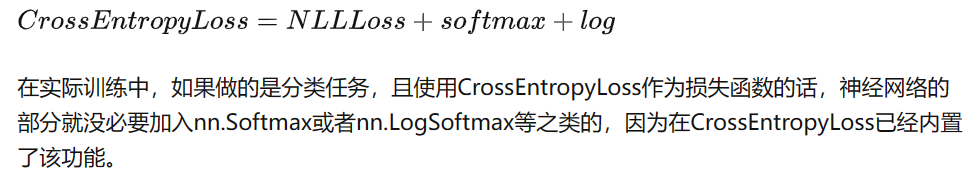

In [ ]:

from torch import nn

class Vgg16_net(nn.Module):
    def __init__(self):
        super(Vgg16_net, self).__init__()

        self.layer1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), #(32-3+2)/1+1=32   32*32*64
            
            nn.BatchNorm2d(64),
            #inplace-选择是否进行覆盖运算
            #意思是是否将计算得到的值覆盖之前的值，比如
            nn.ReLU(inplace=True),
            #意思就是对从上层网络Conv2d中传递下来的tensor直接进行修改，
            #这样能够节省运算内存，不用多存储其他变量

            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), #(32-3+2)/1+1=32    32*32*64
           
            # 数据归一化处理，使分布一致，另一方面避免梯度消失。
            # Batch Normalization强行将数据拉回到均值为0，方差为1的正太分布上，
    
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2,stride=2)   #(32-2)/2+1=16         16*16*64
        )


        self.layer2=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),  #(16-3+2)/1+1=16  16*16*128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), #(16-3+2)/1+1=16   16*16*128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)    #(16-2)/2+1=8     8*8*128
        )

        self.layer3=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),  #(8-3+2)/1+1=8   8*8*256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),


            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),  #(8-3+2)/1+1=8   8*8*256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),  #(8-3+2)/1+1=8   8*8*256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)     #(8-2)/2+1=4      4*4*256
        )

        self.layer4=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),  #(4-3+2)/1+1=4    4*4*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),   #(4-3+2)/1+1=4    4*4*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),   #(4-3+2)/1+1=4    4*4*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)    #(4-2)/2+1=2     2*2*512
        )

        self.layer5=nn.Sequential(
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),   #(2-3+2)/1+1=2    2*2*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),  #(2-3+2)/1+1=2     2*2*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,stride=1,padding=1),  #(2-3+2)/1+1=2      2*2*512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2,2)   #(2-2)/2+1=1      1*1*512
        )


        self.conv=nn.Sequential(
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
            self.layer5
        )

        self.fc=nn.Sequential(
            #y=xA^T+b  x是输入,A是权值,b是偏执,y是输出
            #nn.Liner(in_features,out_features,bias)
                 #in_features:输入x的列数  输入数据:[batchsize,in_features]
                 #out_freatures:线性变换后输出的y的列数,输出数据的大小是:[batchsize,out_features]
            #bias: bool  默认为True
            #线性变换不改变输入矩阵x的行数,仅改变列数
            nn.Linear(512,512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512,256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256,10)
        )


    def forward(self,x):
        x=self.conv(x)
        #这里-1表示一个不确定的数，就是你如果不确定你想要reshape成几行，但是你很肯定要reshape成512列
        # 那不确定的地方就可以写成-1

        #如果出现x.size(0)表示的是batchsize的值
        # x=x.view(x.size(0),-1) (view--->reshape)
        x = x.view(-1, 512) 
        x=self.fc(x)
        return x



import torch
from torch import nn,optim,tensor
from torch.utils.data import DataLoader
from torchvision.utils import  make_grid
from torchvision import datasets,transforms
import numpy as np
from matplotlib import pyplot as plt
import time

#全局变量
batch_size=32   #每次喂入的数据量

# num_print=int(50000//batch_size//4)
num_print=100

epoch_num=30 #总迭代次数

lr=0.01
step_size=10  #每n次epoch更新一次学习率

#数据获取(数据增强,归一化)
def transforms_RandomHorizontalFlip():

    #transforms.Compose(),将一系列的transforms有序组合,实现按照这些方法依次对图像操作

    #ToTensor()使图片数据转换为tensor张量,这个过程包含了归一化,图像数据从0~255压缩到0~1,这个函数必须在Normalize之前使用
    #实现原理,即针对不同类型进行处理,原理即各值除以255,
    #最后通过torch.from_numpy将PIL Image或者 numpy.ndarray()针对具体类型转成torch.tensor()数据类型

    #Normalize()是归一化过程,ToTensor()的作用是将图像数据转换为(0,1)之间的张量,Normalize()则使用公式(x-mean)/std
    #将每个元素分布到(-1,1). 归一化后数据转为标准格式,
    transform_train=transforms.Compose([transforms.RandomHorizontalFlip(),
                      transforms.ToTensor(),
                      transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])


    transform=transforms.Compose([transforms.ToTensor(),
                   transforms.Normalize((0.485,0.456,0.406),(0.226,0.224,0.225))])


    #root:cifar-10 的根目录,data_path
    #train:True=训练集, False=测试集
    #transform:(可调用,可选)-接收PIL图像并返回转换版本的函数
    #download:true=从互联网上下载数据,并将其放在root目录下,如果数据集已经下载,就什么都不干
    train_dataset=datasets.CIFAR10(root='../../data_hub/cifar10/data_1',train=True,transform=transform_train,download=True)
    test_dataset=datasets.CIFAR10(root='../../data_hub/cifar10/data_1',train=False,transform=transform,download=True)

    return train_dataset,test_dataset

#数据增强:随机翻转
train_dataset,test_dataset=transforms_RandomHorizontalFlip()



'''
#Dataloader(....)
dataset:就是pytorch已有的数据读取接口,或者自定义的数据接口的输出,该输出要么是torch.utils.data.Dataset类的对象,
要么是继承自torch.utils.data.Dataset类的自定义类的对象

batch_size:如果有50000张训练集,则相当于把训练集平均分成(50000/batch_size)份,每份batch_size张图片
train_loader中的每个元素相当于一个分组,一个组中batch_size图片,

shuffle:设置为True时会在每个epoch重新打乱数据(默认:False),一般在训练数据中会采用
num_workers:这个参数必须>=0,0的话表示数据导入在主进程中进行,其他大于0的数表示通过多个进程来导入数据,可以加快数据导入速度
drop_last:设定为True如果数据集大小不能被批量大小整除的时候,将丢到最后一个不完整的batch(默认为False)
'''

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

#模型,优化器
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#from VggNet import *

model=Vgg16_net().to(device)

#在多分类情况下一般使用交叉熵
# torch.nn.CrossEntropyLoss相当于softmax + log + nllloss。
# 预测的概率大于1不符合预期，可以使用softmax归一，取log后是交叉熵，取负号是为了符合loss越小，预测概率越大。
# 在实际训练中，如果做的是分类任务，且使用CrossEntropyLoss作为损失函数的话，
# 神经网络的部分就没必要加入nn.Softmax或者nn.LogSoftmax等之类的，因为在CrossEntropyLoss已经内置了该功能。
criterion=nn.CrossEntropyLoss()
'''
params(iterable)-待优化参数的iterable或者定义了参数组的dict
lr(float):学习率

momentum(float)-动量因子

weight_decay(float):权重衰减,使用的目的是防止过拟合.在损失函数中,weight decay是放在正则项前面的一个系数,正则项一般指示模型的复杂度
所以weight decay的作用是调节模型复杂度对损失函数的影响,若weight decay很大,则复杂的模型损失函数的值也就大.

dampening:动量的有抑制因子

optimizer.param_group:是长度为2的list,其中的元素是两个字典
optimzer.param_group:长度为6的字典,包括['amsgrad','params','lr','weight_decay',eps']
optimzer.param_group:表示优化器状态的一个字典

'''
optimizer=optim.SGD(model.parameters(),lr=lr,momentum=0.8,weight_decay=0.001) #神经网络优化器




'''
scheduler 调整学习率而设置，我这里设置的gamma衰减率为0.5，step_size为10，也就是每10个epoch将学习率衰减至原来的0.5倍。
optimizer(Optimizer):要更改学习率的优化器
milestones(list):递增的list,存放要更新的lr的epoch
gamma:(float):更新lr的乘法因子
last_epoch:：最后一个epoch的index，如果是训练了很多个epoch后中断了，继续训练，这个值就等于加载的模型的epoch。
默认为-1表示从头开始训练，即从epoch=1
'''
schedule=optim.lr_scheduler.StepLR(optimizer,step_size=step_size,gamma=0.5,last_epoch=-1)



#训练
loss_list=[]  #为了后续画出损失图
start=time.time()

#train
for epoch in range(epoch_num):
    ww = 0
    running_loss=0.0
    #0是对i的给值(循环次数从0开始计数还是从1开始计数的问题):
    #???
    for i,(inputs,labels) in enumerate(train_loader,0):

        #将数据从train_loader中读出来,一次读取的样本是32个
        inputs,labels=inputs.to(device),labels.to(device)

        #用于梯度清零,在每次应用新的梯度时,要把原来的梯度清零,否则梯度会累加
        optimizer.zero_grad()
        outputs = model(inputs)


        loss=criterion(outputs,labels).to(device)

        #反向传播,pytorch会自动计算反向传播的值
        loss.backward()
        #对反向传播以后对目标函数进行优化
        optimizer.step()


        running_loss+=loss.item()
        loss_list.append(loss.item())

        if(i+1)%num_print==0:
            print('[%d epoch,%d]  loss:%.6f' %(epoch+1,i+1,running_loss/num_print))
            running_loss=0.0

    lr_1=optimizer.param_groups[0]['lr'] #返回优化器的第一个参数组的学习率
    print("learn_rate:%.15f"%lr_1)
    schedule.step() #10 per epoch

end=time.time()
print("time:{}".format(end-start))




#测试

#由于训练集不需要梯度更新,于是进入测试模式
model.eval()
correct=0.0
total=0
with torch.no_grad(): #训练集不需要反向传播
    print("=======================test=======================")
    for inputs,labels in test_loader:
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=model(inputs)

        pred=outputs.argmax(dim=1)  #返回每一行中最大值元素索引
        total+=inputs.size(0)    #输入张量的第一维度的大小
        correct+=torch.eq(pred,labels).sum().item() #sum()返回张量中所有元素的总和，item()返回标量张量的值

print("Accuracy of the network on the 10000 test images:%.2f %%" %(100*correct/total) )
print("===============================================")


Files already downloaded and verified
Files already downloaded and verified
[1 epoch,100]  loss:2.085426
[1 epoch,200]  loss:1.873188
[1 epoch,300]  loss:1.771272
[1 epoch,400]  loss:1.655227
[1 epoch,500]  loss:1.628850
[1 epoch,600]  loss:1.590795
[1 epoch,700]  loss:1.483473
[1 epoch,800]  loss:1.456820
[1 epoch,900]  loss:1.415111
[1 epoch,1000]  loss:1.351101
[1 epoch,1100]  loss:1.314040
[1 epoch,1200]  loss:1.276708
[1 epoch,1300]  loss:1.270549
[1 epoch,1400]  loss:1.215296
[1 epoch,1500]  loss:1.169319
learn_rate:0.010000000000000
[2 epoch,100]  loss:1.128866
[2 epoch,200]  loss:1.113176
[2 epoch,300]  loss:1.053775
[2 epoch,400]  loss:1.059447
[2 epoch,500]  loss:1.023630
[2 epoch,600]  loss:1.073125
[2 epoch,700]  loss:1.021277
[2 epoch,800]  loss:0.998639
[2 epoch,900]  loss:0.995209
[2 epoch,1000]  loss:0.945179
[2 epoch,1100]  loss:0.942764
[2 epoch,1200]  loss:0.932323
[2 epoch,1300]  loss:0.953590
[2 epoch,1400]  loss:0.904688
[2 epoch,1500]  loss:0.932299
learn_rate:0.